For running the segmentation and classification networks locally on sample images. 

Bulk of the functionality comes from deploy.py

Hit 'shift-tab' to view more info on the functions used.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from deploy import load_segmentation, load_classifier, run_model, denorm_img, load_bin_classifiers, segment_and_classify, visualise
from segmenter import g_fns, show_img
from fastai.conv_learner import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(True, True)

In [2]:
PATH = '/home/sean/hpc-home/skin_cancer'

In [3]:
segnet, seg_tfm = load_segmentation(path=PATH)

clnet, cl_tfm = load_classifier('res_101_class_multi_seg_pret_2018-12-17_2', 'train_classes_multi_halfn.csv', path=PATH)

Saving model as "Unused: can be anything here"
-> Train set value counts
nevus        4164
melanoma     1221
keratosis     562
Name: classes, dtype: int64
Dataset has: ['keratosis', 'melanoma', 'nevus'] classes
Cuda: True; Cudnn True


In [4]:
cls2str = {0: 'keratosis', 1: 'melanoma', 2: 'benign nevus'}  # order for 3-class lesion classification.

In [5]:
img_fns = g_fns('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Data_Classification', ext='.jpg')
lbl = pd.read_csv('/home/sean/hpc-home/skin_cancer/ISIC/test_isic17.csv', index_col=[0])
lbl[lbl == 'seborrheic_keratosis'] = 'keratosis'

In [6]:
lbl.head()

,classes
image_id,
ISIC_0012086,keratosis
ISIC_0012092,nevus
ISIC_0012095,nevus
ISIC_0012134,keratosis
ISIC_0012136,keratosis


len 12; cls - [1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1]
CPU times: user 10.1 s, sys: 3.81 s, total: 13.9 s
Wall time: 12.7 s


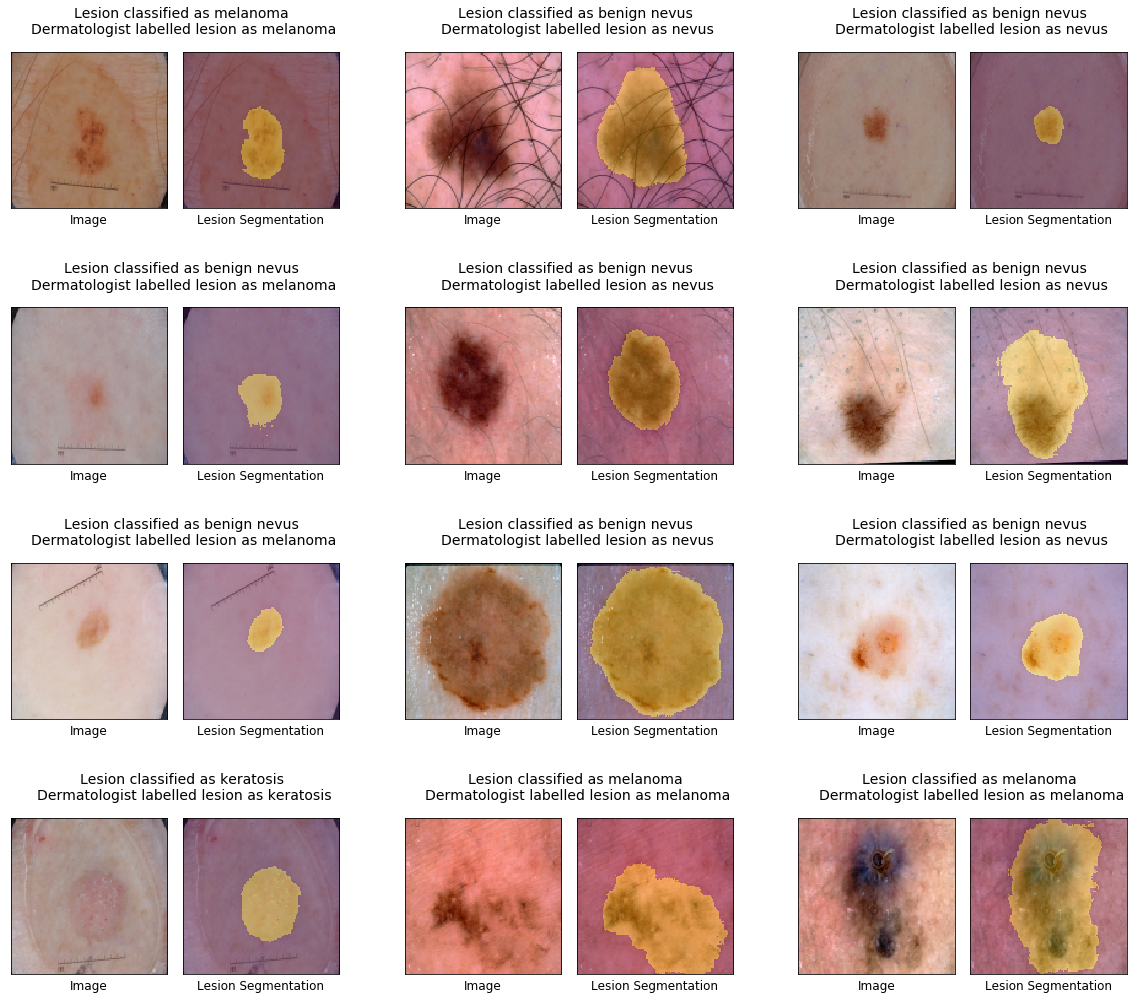

In [7]:
%%time
# get predictions of 9 ramdom images from the testset.
ran_ims = np.random.choice(img_fns, size=(12,))
cs, ss = segment_and_classify(ran_ims, clnet, segnet, class_tfm=cl_tfm, seg_tfm=seg_tfm)
print(f'len {len(cs)}; cls - {cs}')
visualise(cs, ss, inp_ims=ran_ims, lbl_df=lbl, cls2str=cls2str)

len 12; cls - [2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2]
CPU times: user 10.5 s, sys: 3.81 s, total: 14.3 s
Wall time: 13.2 s


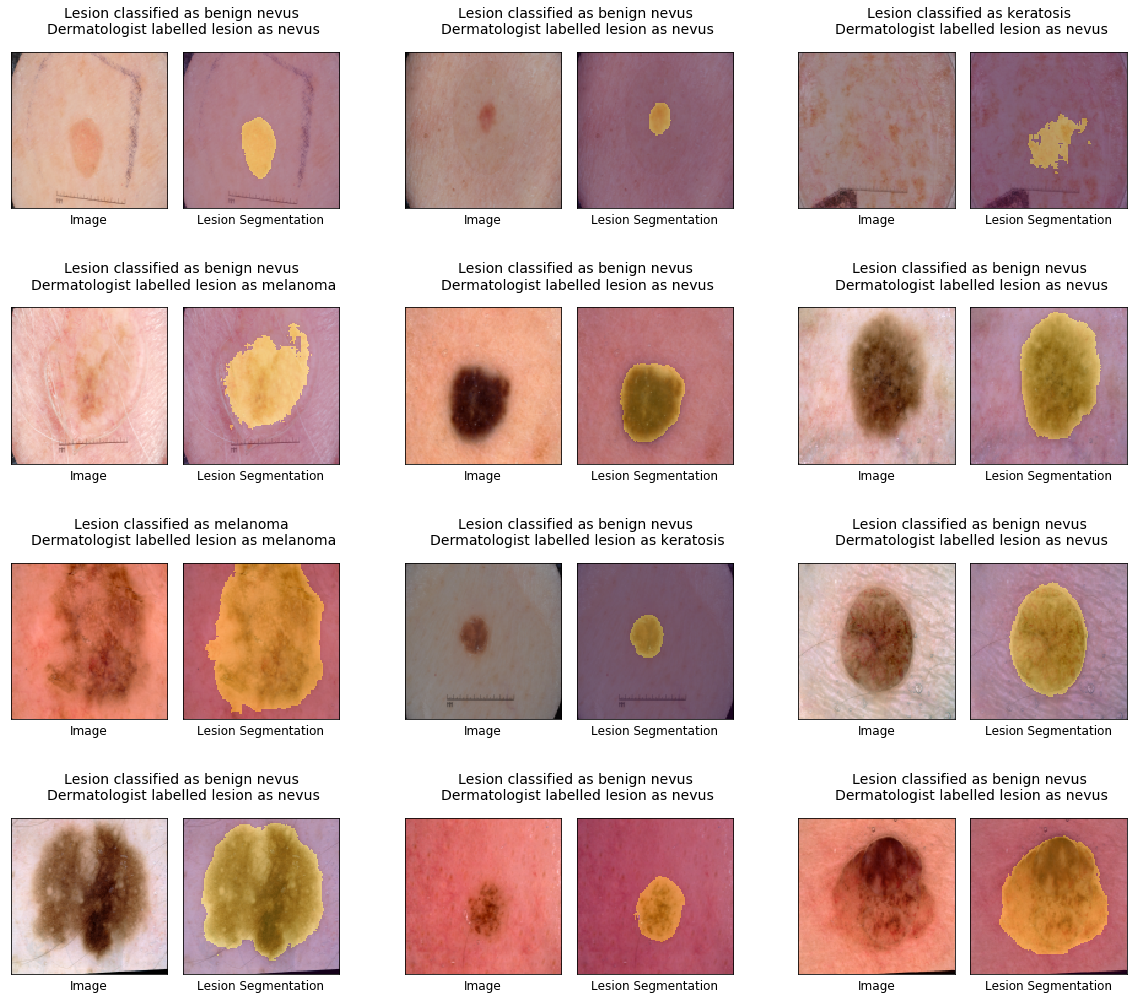

In [9]:
%%time
# get predictions of 9 ramdom images from the testset.
ran_ims = np.random.choice(img_fns, size=(12,))
cs, ss = segment_and_classify(ran_ims, clnet, segnet, class_tfm=cl_tfm, seg_tfm=seg_tfm)
print(f'len {len(cs)}; cls - {cs}')
visualise(cs, ss, inp_ims=ran_ims, lbl_df=lbl, cls2str=cls2str)